Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Paula Miralles Simó"
COLLABORATORS = "Jordi Puig Benages"

---

![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png)  ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png)
# Activitat 4: Octubre 2023

## Extracció de coneixement de fonts de dades heterogènies mitjançant Spark SQL, RDDs i GraphFrames

En aquesta pràctica anem a introduir els elements que ofereix Spark per treballar amb estructures de dades. Veurem des d'estructures molt simples fins a estructures complexes,n els camps poden al seu torn tenir camps imbricats. En concret utilitzarem dades de twitter capturats en el context de les eleccions generals a Espanya de l'28 d'Abril de 2019. La pràctica està estructurada de la següent manera:
- **Part 0:** Configuració de l'entorn
- **Part 1:** Introducció a data frames estructurats i com operar extreure informació *(2 punts)*
    - **Part 1.1:** Importa les dades *(0.25 punts)*
    - **Part 1.2:** *Queries* sobre sobre data frames complexos *(1.75 punts)*
        - **Part 1.2.1:** Queries SQL *(0.75 punts)*
        - **Part 1.2.2:** Queries sobre el pipeline *(1 punt)*
- **Part 2:** Bases de dades HIVE i operacions complexes *(3 punts)*
    - **Part 2.1:** Bases de dades Hive *(0.25 punts)*
    - **Part 2.2:** Més enllà de les transformacions SQL *(2.75 punts)*
        - **Part 2.2.1:** Tweets per població  *(1.25 punts)*
            - **Part 2.2.1.1:** Utilizant SQL *(0.25 punts)*
            - **Part 2.2.1.2:** Utilizant RDD *(1 punt)*
        - **Part 2.2.2:** Comptar hashtags *(1.5 punts)*
- **Part 3:** Sampling *(1.5 punts)*
    - **Part 3.1:** Homogeni *(0.5 punt)*
    - **Part 3.2:** Estratificat *(1 punts)*
- **Part 4**: Introducció a les dades relacionals *(1.5 punts)*
    - **Part 4.1:** Generar la xarxa de retweets *(1 punt)*
        - **Part 4.1.1**: Construcció de l'edgelist *(0.5 punts)*
        - **Part 4.1.2**: Centralidad de grau *(0.5 punts)*
    - **Part 4.2:** Anàlisi de xarxes utilitzant GraphFrames *(0.5 punt)*
- **Part 5**: Preguntes teòriques *(2 punts)*    

## **Part 0:** Configuració del entorn

In [2]:
import findspark
findspark.init()

In [3]:
import re
import os
import pandas as pd
from matplotlib import pyplot as plt
from math import floor
from pyspark import SparkConf, SparkContext, SQLContext, HiveContext
from pyspark.sql import Row

In [4]:
SUBMIT_ARGS = "--jars /opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/jars/graphframes_graphframes-0.7.0-spark2.4-s_2.11.jar pyspark-shell"

os.environ["PYSPARK_SUBMIT_ARGS"] = SUBMIT_ARGS

conf = SparkConf()
conf.setMaster("local[1]")
# Introduïu el nom de l'app PAC3_ seguit del vostre nom d'usuari
conf.setAppName("PAC3_jpuigben")
sc = SparkContext(conf=conf)

## **Part 1:** Introducció a DataFrames estructurats i operacions sobre ells.

Com ja s'ha esmentat, en aquesta pràctica utilitzarem dades de Twitter que es van recollir durant les eleccions generals a Espanya de l'28 d'abril de 2019. Com veurem, els tweets tenen una estructura interna força complexa tot i que s'ha simplificat una mica en aquesta pràctica.

### **Part 1.1:** Importa les dades

El primer que anem ha aprendre és com importar aquest tipus de dades al nostre entorn. Un dels tipus d'arxius més comuns per guardar aquest format d'informació és [l'estructura JSON] (https://en.wikipedia.org/wiki/JSON). Aquesta estructura permet registrar informació en text pla de diferents objectes seguint una estructura de diccionari on cada camp té assignat una clau i un valor. L'estructura pot ser imbricada, o sigui que una clau pot tenir com a valor una altra estructura tipus diccionari.

Spark SQL permet llegir dades de molts formats diferents. En aquesta ocasió, se us demana que llegiu un [fitxer JSON](https://spark.apache.org/docs/2.4.0/sql-data-sources-json.html) de la ruta ```/aula_M2.858/data/tweets28a_sample.json```. Aquest fitxer conté un petit *sample*, 0.1% de la base de dades completa (en un següent apartat veurem com realitzar aquest *samplejat*). En aquesta ocasió a la funció read no cal especificar l'estructura de l'DataFrame ja que la funció de lectura la inferirà automàticament.

**Esquema**

```Python
sqlContext = SQLContext(sc)
tweets_sample = sqlContext.read.<FILL IN>

print("Loaded dataset contains %d tweets" % tweets_sample.count())
```

In [5]:
# YOUR CODE HERE

filename = "/aula_M2.858/data/tweets28a_sample.json"

sqlContext = SQLContext(sc)
tweets_sample = sqlContext.read.json(filename)

In [6]:
assert tweets_sample.count() == 27268, "Incorrect answer"

El següent pas és mostrar l'estructura del dataset que acabem de carregar.Podeu obtenir la informació sobre com està estructurat el DataTable utilitzant el mètode ```printSchema()```de la variable `tweets_sample`.

In [7]:
# YOUR CODE HERE
tweets_sample.printSchema()

root
 |-- _id: string (nullable = true)
 |-- created_at: long (nullable = true)
 |-- lang: string (nullable = true)
 |-- place: struct (nullable = true)
 |    |-- bounding_box: struct (nullable = true)
 |    |    |-- coordinates: array (nullable = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: double (containsNull = true)
 |    |    |-- type: string (nullable = true)
 |    |-- country_code: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- place_type: string (nullable = true)
 |-- retweeted_status: struct (nullable = true)
 |    |-- _id: string (nullable = true)
 |    |-- user: struct (nullable = true)
 |    |    |-- followers_count: long (nullable = true)
 |    |    |-- friends_count: long (nullable = true)
 |    |    |-- id_str: string (nullable = true)
 |    |    |-- lang: string (nullable = true)
 |    

Podeu observar que l'estructura de la piulada conté múltiples camps imbricats. Heu de familiaritzar-vos amb aquesta estructura ja que serà la què utilitzarem durant tota aquesta pràctica. Recordeu també que no tots els tweets tenen tots els camps, com ara la ubicació (camp ```place```). Quan això passa el camp és ```NULL```. Podeu veure mes informació sobre aquest tipus de dades en [aquest enllaç](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object).

### **Part 1.2:** *Queries* sobre sobre data frames complexos



En aquesta part de la pràctica veurem com fer consultes sobre el dataset que acabem de carregar. A la primera part anem ha utilitzar [sentències *SQL*](https://www.w3schools.com/sql/default.asp) (com les utilitzades en la majoria de bases de dades relacionals). Per finalitzar veurem un sistema alternatiu per fer consultes utilitzant una aproximació més semblant a la que vau veure a la primera PAC.

#### **Part 1.2.1:** Queries SQL

En primer lloc anem a registrar el nostre DataFrame com una taula de SQL anomenat ```tweets_sample```. Com que és possible que repeteixis aquesta pràctica diverses vegades, anem a prendre la precaució d'eliminar qualsevol taula existent en primer lloc.

Podem eliminar qualsevol taula SQL existent `tweets_sample` usant la sentència SQL: `DROP TABLE IF EXISTS tweets_sample`. Per executar una ordre sql només heu de fer servir el mètode SQL de l'objecte context, en aquest cas `sqlContext`.

Un cop executat el pas anterior, podem registrar el nostre DataFrame com una taula de SQL utilitzant [sqlContext.registerDataFrameAsTable()](https://spark.apache.org/docs/2.4.0/api/python/pyspark.sql.html#pyspark.sql.SQLContext.registerDataFrameAsTable).

**Esquema**
```Python
sqlContext.sql(<FILL IN>)
sqlContext.registerDataFrameAsTable(<FILL IN>)
```

In [8]:
# YOUR CODE HERE
sqlContext.sql("DROP TABLE IF EXISTS tweets_sample")

sqlContext.registerDataFrameAsTable(tweets_sample, "tweets_sample")

In [9]:
assert sqlContext.sql("SELECT * FROM tweets_sample").count() == 27268, "Incorrecct answer"

Ara es demana que creeu una taula ```users_agg``` amb [la informació agregada] (https://www.w3schools.com/sql/sql_groupby.asp) dels usuaris que tinguin definit el seu idioma (``` user.lang```) com espanyol (```es```). En concret se us demana que la taula contingui les següents columnes:
- **screen_name:** nom de l'usuari
- **friends_count:** nombre màxim (veure nota) de persones a les que segueix
- **tweets:** nombre de tweets realitzats
- **followers_count:** nombre màxim (veure nota) persones que segueixen a l'usuari.

L'ordre en què s'han de mostrar els registres és ordre descendent d'acord amb el nombre de tweets.

***Nota:*** és important que us fixeu en què el nom de *friends* i *followers* pot diferir al llarg de l'adquisició de dades. En aquest cas anem a utilitzar la funció d'agregació ```MAX``` sobre cadascun d'aquests camps per evitar segmentar l'usuari en diverses instàncies.

**Esquema**
```Python
users_agg = sqlContext.sql(<FILL IN>)
users_agg.limit(10).show()
```

In [10]:
# YOUR CODE HERE
users_agg= sqlContext.sql("""SELECT user.screen_name, 
                                    MAX(user.friends_count) as friends_count, 
                                    COUNT(DISTINCT(_id)) as tweets, 
                                    MAX(user.followers_count) as followers_count 
                             FROM tweets_sample
                             WHERE user.lang='es' 
                             GROUP BY 1 
                             ORDER BY 3 DESC""")

users_agg.limit(10).show()

+---------------+-------------+------+---------------+
|    screen_name|friends_count|tweets|followers_count|
+---------------+-------------+------+---------------+
|       anaoromi|         6258|    16|           6774|
|    RosaMar6254|         6208|    14|           6245|
|        lyuva26|         3088|    13|           3732|
|PisandoFuerte10|         2795|    12|           1752|
|     carrasquem|          147|    12|            215|
|       jasalo54|         1889|    11|            689|
|  PabloChabolas|         4925|     9|           4042|
|      lolalailo|         4922|     9|           3738|
|     Lordcrow11|         5002|     9|           3069|
|    DuroBelinda|         5242|     9|           5778|
+---------------+-------------+------+---------------+



In [11]:
output = users_agg.first()
assert output.screen_name == 'anaoromi' and output.friends_count == 6258 and output.tweets == 16 and output.followers_count == 6774, "Incorrect output"

Imagineu ara que volem combinar la informació que acabem de generar amb informació sobre el nombre de vegades que un usuari ha estat retuitejat. Per fer aquest tipus de combinacions necessitem recórrer a l'[```JOIN``` de taules](https://www.w3schools.com/sql/sql_join.asp). Primer hem de registrar la taula que acabem de generar en el context SQL. Recordeu que primer heu de comprovar si la taula existeix i en cas afirmatiu eliminar-la. La taula heu de registrar-la sota el nom de ```user_agg```.

In [12]:
# YOUR CODE HERE
sqlContext.sql("DROP TABLE IF EXISTS user_agg")

sqlContext.registerDataFrameAsTable(users_agg, "user_agg")

In [13]:
assert sqlContext.sql("SELECT * FROM user_agg").count() == 17925, "Incorrect answer"

Un cop registrada es demana que combineu aquesta taula i la taula ```tweets_sample``` servir un ``` INNER JOIN``` per obtenir una nova taula amb la següent informació:
- ***screen_name:*** nom d'usuari
- ***friends_count:*** nombre màxim de persones a les que segueix
- ***followers_count:*** nombre màxim de persones que segueixen a l'usuari.
- ***tweets:*** nombre de tweets realitzats per l'usuari.
- ***retweeted:*** nombre de retweets obtinguts per l'usuari.
- ***ratio_tweet_retweeted:*** ràtio de retweets per nombre de tweets publicats $\frac{retweets}{tweets}$

La taula resultate ha d'estar ordenada de manera descendent segons el valor de la columna```ratio_tweet_retweeted```

**Esquema**
```Python
retweeted = sqlContext.sql(<FILL IN>)

retweeted.limit(10).show()
```

In [14]:
# YOUR CODE HERE

retweeted= sqlContext.sql("""SELECT u.screen_name,
                                    u.friends_count,
                                    u.followers_count,
                                    u.tweets,
                                    COUNT(DISTINCT(t._id)) as retweeted,
                                    COUNT(DISTINCT(t._id))/tweets as ratio_tweet_retweeted
                             FROM user_agg u
                             INNER JOIN tweets_sample t
                             ON u.screen_name=t.retweeted_status.user.screen_name
                             GROUP BY 1,2,3,4
                             ORDER BY 6 DESC""")

retweeted.limit(10).show()

+--------------+-------------+---------------+------+---------+---------------------+
|   screen_name|friends_count|followers_count|tweets|retweeted|ratio_tweet_retweeted|
+--------------+-------------+---------------+------+---------+---------------------+
|          PSOE|        13635|         671073|     1|      155|                155.0|
|  CiudadanosCs|        92910|         511896|     1|      117|                117.0|
|     JuntsXCat|          202|          88515|     1|       73|                 73.0|
|  PartidoPACMA|         1498|         232932|     1|       63|                 63.0|
|  pablocasado_|         4567|         238926|     1|       50|                 50.0|
|voxnoticias_es|         2146|          29582|     1|       44|                 44.0|
|RaiLopezCalvet|         7579|          13574|     1|       43|                 43.0|
|        iunida|        10225|         558318|     1|       39|                 39.0|
|        Xuxipc|          311|         184967|     1| 

In [15]:
output = retweeted.first()
assert output.screen_name == 'PSOE' and output.friends_count == 13635 and output.tweets == 1 and output.followers_count == 671073 and output.ratio_tweet_retweeted == 155.0 and output.retweeted == 155, "Incorrect output"

#### **Part 1.2.2:** Queries mijançant el pipeline

Les taules de Spark SQL ofereixen un altre mecanisme per aplicar les transformacions i obtenir resultats similars als que s'obtindria aplicant una consulta SQL. Per exemple utilitzant el següent pipeline obtindrem el text de tots els tweets en espanyol:

```
tweets_sample.where("lang == 'es'").select("text")
```

L'anterior instrucció és equivalent a la següent sentència SQL:
```
SELECT text
FROM tweets_sample
WHERE lang == 'es'
```

Podeu consultar el [API de spark SQL](https://spark.apache.org/docs/2.4.0/api/python/pyspark.sql.html) per trobar més informació sobre com utilitzar les diferents transformacions sobre taules.

En aquest exercici es demana que repliqueu la query obtinguda a l'apartat anterior generant primerament la taula ```users_agg```. Podeu utilitzar les transformacions ```where```, ```select``` (o ```selectExpr```), ```groupBy```, ```count```, ```agg``` i ```orderBy```

**Esquema**
```Python
users = tweets_sample.where(<FILL IN>).select(<FILL IN>)

users_agg = users.groupBy(<FILL IN>)\
                 .agg(<FILL IN>)\
                 .orderBy(<FILL IN>)

users_agg.limit(10).show()
```

In [16]:
# YOUR CODE HERE
users= tweets_sample.where("user.lang=='es'").select("user.screen_name","user.friends_count","_id", "user.followers_count")

users_agg=users.groupBy("screen_name").agg({"_id":"count","friends_count":"max","followers_count":"max"}).orderBy("count(_id)",ascending=False)
users_agg.limit(10).show()

+---------------+------------------+--------------------+----------+
|    screen_name|max(friends_count)|max(followers_count)|count(_id)|
+---------------+------------------+--------------------+----------+
|       anaoromi|              6258|                6774|        16|
|    RosaMar6254|              6208|                6245|        14|
|        lyuva26|              3088|                3732|        13|
|PisandoFuerte10|              2795|                1752|        12|
|     carrasquem|               147|                 215|        12|
|       jasalo54|              1889|                 689|        11|
|  PabloChabolas|              4925|                4042|         9|
|      lolalailo|              4922|                3738|         9|
|     Lordcrow11|              5002|                3069|         9|
|    DuroBelinda|              5242|                5778|         9|
+---------------+------------------+--------------------+----------+



In [17]:
output = users_agg.first()
assert output.screen_name == 'anaoromi'

Si us fixeu veureu que el nom de les columnes no correspon amb l'obtingut anteriorment, podeu canviar el nom d'una columna determinada utilitzant la transfomació ```withColumnRenamed```. Canvieu el nom de les columnes perquè coincideixin amb l'apartat anterior i les guardeu en una variable ```user_agg_new```.

**Esquema**
```Python
users_agg_new = users_agg.withColumnRenamed(<FILL IN>)\
                         .withColumnRenamed(<FILL IN>)\
                         .withColumnRenamed(<FILL IN>)

users_agg_new.limit(10).show()
```

In [18]:
# YOUR CODE HERE
users_agg_new = users_agg.withColumnRenamed('count(_id)','tweets').withColumnRenamed("max(followers_count)",'followers_count').withColumnRenamed("max(friends_count)","friends_count")

In [19]:
output = users_agg_new.first()
assert output.screen_name == 'anaoromi' and output.friends_count == 6258 and output.tweets == 16 and output.followers_count == 6774, "Incorrect output"

Creeu ara una taula ```user_retweets``` utilitzant transformacions que contingui dues columnes:
- ***screen_name:*** nom d'usuari
- ***retweeted:*** nombre de retweets

Podeu utilitzar les mateixes transformacions que en l'exercici anterior. Ordeneu la taula en ordre descendent utilitzant el valor de la columna ```retweeted```.

**Esquema**
```Python
user_retweets = tweets_sample.<FILL IN>

user_retweets.limit(10).show()
```

In [20]:
# YOUR CODE HERE
user_retweets = tweets_sample.where("retweeted_status IS NOT NULL").select("retweeted_status.user.screen_name","_id").groupBy('screen_name').agg({"_id":"count"}).orderBy("count(_id)",ascending=False).withColumnRenamed("count(_id)",'retweeted')
user_retweets.limit(10).show()

+--------------+---------+
|   screen_name|retweeted|
+--------------+---------+
|        vox_es|      299|
|  ahorapodemos|      238|
| Santi_ABASCAL|      238|
|      iescolar|      166|
| AlbanoDante76|      161|
|          PSOE|      155|
|AntonioMaestre|      154|
|          KRLS|      149|
|        boye_g|      142|
|  CiudadanosCs|      117|
+--------------+---------+



In [21]:
output = user_retweets.first()
assert output.screen_name == 'vox_es' and output.retweeted == 299, "Incorrect output"

Una altra manera de combinar dues taules és utilitzant el [mètode de taula ```join```](https://spark.apache.org/docs/2.4.0/api/python/pyspark.sql.html). Combineu la informació de la taula ```users_agg_new``` i ``` user_retweets``` en una nova taula ```retweeted``` utilitzant la columna ``` screen_name```. Ordeneu la nova taula en ordre descendent segons el nom de retweets.

**Esquema**

```Python
retweeted = users_agg_new.join(<FILL IN>)\
                         .orderBy(<FILL IN>)

retweeted.limit(10).show()
```

In [22]:
# YOUR CODE HERE
user_retweets = tweets_sample.where("retweeted_status IS NOT NULL").select("retweeted_status.user.screen_name","_id").groupBy('screen_name').agg({"_id":"count"}).orderBy("count(_id)",ascending=False).withColumnRenamed("count(_id)",'retweeted')
user_retweets.limit(10).show()

+--------------+---------+
|   screen_name|retweeted|
+--------------+---------+
|        vox_es|      299|
|  ahorapodemos|      238|
| Santi_ABASCAL|      238|
|      iescolar|      166|
| AlbanoDante76|      161|
|          PSOE|      155|
|AntonioMaestre|      154|
|          KRLS|      149|
|        boye_g|      142|
|  CiudadanosCs|      117|
+--------------+---------+



In [23]:
output = retweeted.first()
assert output.screen_name == 'PSOE' and output.friends_count == 13635 and output.tweets == 1 and output.followers_count == 671073 and output.retweeted == 155, "Incorrect output"

Notareu que alguns dels registres que apareixen en el la taula ```users_retweeted``` no estan presents a la taula retweeted. Això és degut al fet que per defecte el mètode aplica un inner join i per tant només combina els registres presents en ambdues taules. Podeu canviar aquest comportament a través dels paràmetres de la funció.

Per acabar aquesta part i reconstruir el resultat de l'apartat 1.2.1 anem a afegir una columna ```ratio_tweet_retweeted``` amb informació del ràtio entre retweets i tweets. Per a això heu d'utilitzar la transformació ```withColumn```. El resultat ha d'estar ordenat per aquesta nova columna en ordre descendent.

**Esquema**
```Python
retweeted = retweeted.withColumn(<FILL IN>)
retweeted.limit(10).show()
```

In [24]:
# YOUR CODE HERE
retweeted = retweeted.withColumn('ratio_tweet_retweeted',retweeted.retweeted/retweeted.tweets)
retweeted.limit(10).show()

+--------------+-------------+---------------+------+---------+---------------------+
|   screen_name|friends_count|followers_count|tweets|retweeted|ratio_tweet_retweeted|
+--------------+-------------+---------------+------+---------+---------------------+
|          PSOE|        13635|         671073|     1|      155|                155.0|
|  CiudadanosCs|        92910|         511896|     1|      117|                117.0|
|     JuntsXCat|          202|          88515|     1|       73|                 73.0|
|  PartidoPACMA|         1498|         232932|     1|       63|                 63.0|
|  pablocasado_|         4567|         238926|     1|       50|                 50.0|
|voxnoticias_es|         2146|          29582|     1|       44|                 44.0|
|RaiLopezCalvet|         7579|          13574|     1|       43|                 43.0|
|        iunida|        10225|         558318|     1|       39|                 39.0|
|        Xuxipc|          311|         184967|     1| 

In [25]:
output = retweeted.first()
assert output.screen_name == 'PSOE' and output.friends_count == 13635 and output.tweets == 1 and output.followers_count == 671073 and output.ratio_tweet_retweeted == 155.0 and output.retweeted == 155, "Incorrect output"

## **Part 2:** Bases de dades HIVE i operacions complexes

Fins ara hem estat treballant amb un petit sample dels tweets generats (el 01%). En aquesta part de la PAC veurem com treballar i tractar el dataset complet per a això utilitzarem transformacions sobre taules i operacions sobre RDD quan sigui necessari.

### **Part 2.1:** Bases de dades Hive

Moltes vegades les dades s'utilitzen en varis projectes de manera simultània. Una manera d'organitzar les dades és, en lloc d'utilitzar directament els fitxers, recórrer a una base de dades per gestionar la informació. En l'entorn Hadoop una de les bases de dades més comuns és [Apache Hive](https://hive.apache.org/), una base de dades que permet treballar amb contingut distribuït.

La manera d'accedir a aquesta base de dades és creant un context Hive de manera molt similar a com vam declarar un context SQL. Primer de tot anem a declarar una variable ```hiveContext``` creant una instància com un objecte de la classe ``` HiveContext```. Tot seguit anem a comprovar quantes taules estan registrades en aquest context.

**Esquema**
```Python
hiveContext = <FILL IN>
hiveContext.tables().show()
```

In [26]:
# YOUR CODE HERE
hiveContext = HiveContext(sc)
hiveContext.tables().show()

+--------+------------------+-----------+
|database|         tableName|isTemporary|
+--------+------------------+-----------+
| default|            d_pais|      false|
| default| d_tipo_habitacion|      false|
| default|      province_28a|      false|
| default|         tweets28a|      false|
| default|     tweets28afull|      false|
| default|tweets28a_sample25|      false|
| default|         user_info|      false|
| default|     user_info_old|      false|
|        |     tweets_sample|       true|
|        |          user_agg|       true|
+--------+------------------+-----------+



Observeu que ara mateix tenim cinc taules registrades en aquest context. Tres d'elles no temporals i dues temporals, les que hem registrat prèviament. Per tant sqlContext i hiveContext estan connectats (és la mateixa sessió)

Anem ha crear la variable ```tweets``` que utilitzarem per accedir a la taula ``` tweets28a_sample25``` guardada a ```hiveContext``` utilitzant el mètode ``` table () ``` d'aquest objecte.

**Esquema**
```Python
tweets = <FILL IN>
print("Loaded dataset contains {} tweets".format(tweets.count()))
```

In [87]:
# YOUR CODE HERE
tweets = hiveContext.table('tweets28a_sample25')

In [28]:
assert tweets.count() == 6354961, "Incorrect Answer"

Utilitzant el mateix mètode utilitzat en l'apartat 1.1, comproveu l'estructura de la taula que acabem de carregar.

In [29]:
# YOUR CODE HERE
tweets.printSchema()

root
 |-- _id: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- lang: string (nullable = true)
 |-- place: struct (nullable = true)
 |    |-- bounding_box: struct (nullable = true)
 |    |    |-- coordinates: array (nullable = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: double (containsNull = true)
 |    |    |-- type: string (nullable = true)
 |    |-- country_code: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- place_type: string (nullable = true)
 |-- retweeted_status: struct (nullable = true)
 |    |-- _id: string (nullable = true)
 |    |-- user: struct (nullable = true)
 |    |    |-- followers_count: long (nullable = true)
 |    |    |-- friends_count: long (nullable = true)
 |    |    |-- id_str: string (nullable = true)
 |    |    |-- lang: string (nullable = true)
 

### **Part 2.2:** Més enllà de les transformacions SQL

Algunes vegades necessitarem obtenir resultats que necessiten operacions que van mes enllà del que podem aconseguir utilitzant el llenguatge SQL. En aquesta part de la pràctica anem practicar com passar d'una taula a un RDD, per fer operacions complexes, i després tornar a passar a una taula.

#### **Part 2.2.1:** piulades per població
##### **Part 2.2.1.1:** Utilitzant SQL
Un petit percentatge, al voltant de l'1%, dels tweets realitzats està geolocalitzat. Això vol dir que per a aquests tweets tenim informació sobre el lloc on han estat realitzats guardat en el camp ```place```. En aquest exercici es demana que utilitzant una sentència SQL mostreu en ordre descendent quants tweets s'han realitzat en cada lloc. La taula resultant ```tweets_place``` ha de tenir les següents columnes:
- ***name:*** nom de el lloc
- ***tweets:*** nombre de tweets

Recordeu que no tots els tweets a la base de dades han de tenir informació geolocalitzada, heu de filtrar-tenint en compte tots els que tenen un valor no nul. La taula ha d'estar en ordre descendent por nombre de tweets.

**Esquema**
```Python
tweets_place = hiveContext.sql(<FILL IN>)
tweets_place.limit(10).show()
```

In [89]:
# YOUR CODE HERE
hiveContext.registerDataFrameAsTable(tweets, "tweets")

tweets_place = hiveContext.sql("""SELECT place.name as name,
                                         COUNT(DISTINCT(_id)) as tweets   
                                 FROM tweets 
                                 WHERE place IS NOT NULL
                                 GROUP BY 1
                                 ORDER BY 2 DESC
                             """)

In [31]:
output = tweets_place.first()
assert output.name == "Madrid" and output.tweets == 4911, "Incorrect output"

##### **Part 2.2.1.2:** Utilitzant RDD

Ara es demana que feu el mateix però aquesta vegada utilitzant RDD per realitzar l'agregació (recordeu els exercicis de comptar paraules que vau fer a la PAC 1).

El primer pas consisteix a generar un taula ```tweets_geo``` que només contingui informació de tweets geolocalitzats amb una sola columna:
- ***name:*** nom de el lloc des d'on s'ha generat el tweet

**Esquema**
```Python
tweets_geo = <FILL IN>
```

In [32]:
# YOUR CODE HERE
tweets_geo=hiveContext.sql("SELECT place.name FROM tweets WHERE place IS NOT NULL")

In [33]:
assert tweets_geo.count() == 44477, "Incorrect answer"

El punt clau és que una taula pot esdevenir un RDD a través de l'atribut ```.rdd```. Aquest atribut guarda la informació de la taula en una llista on cada element és un [objecte del tipus ```Row```](https://spark.apache.org/docs/2.4.0/api/python/pyspark.sql.html#pyspark.sql.Row). Els objectes pertanyents a aquesta classe es poden veure com diccionaris on la informació de les diferents columnes queda reflectida en forma d'atribut. Per exemple, imagineu que tenim una taula amb dues columnes, nom i cognom, si utilitzem l'atribut ```.rdd``` d'aquesta taula obtindrem una llista amb objectes del tipus row on cada objecte té dos atributs: nom i cognom. Per accedir als atributs només hem de fer servir la sintaxi *punt* de Python, e.g., ```row.nombre``` o ``` row.apellido```.

En aquesta part de l'exercici es demana que creeu un objecte ```tweets_lang_rdd``` que contingui una llista de tuples amb la informació ``` (name, tweets) ``` sobre el nom del lloc i el nombre de tweets generats des del mateix. Recordeu l'exercici de comptar paraules de la PAC 1.

**Esquema**
```Python
tweets_place_rdd = tweets_geo.<FILL IN>
```

In [34]:
# YOUR CODE HERE
tweets_place_rdd = tweets_geo.rdd.map(lambda x: (x[0],1)).reduceByKey(lambda a,b: a+b)

In [35]:
assert tweets_place_rdd.count() == 4038, "Incorrect output"

Un cop generat aquest RDD crearem un taula. El primer pas és generar per cada tupla un objecte Row que contingui un atribut ```name``` i un atribut ``` tweets```. Ara només heu d'aplicar el mètode ```toDF ()``` per generar una taula. Ordeneu les files d'aquesta taula pel nombre de tweets en ordre descendent.

**Esquema**
```Python
tweets_place = tweets_place_rdd.<FILL IN>

tweets_place.limit(10).show()
```

In [36]:
# YOUR CODE HERE
tweets_place = tweets_place_rdd.toDF(["name","tweets"]).orderBy('tweets', ascending=False)

tweets_place.limit(10).show()

+-----------+------+
|       name|tweets|
+-----------+------+
|     Madrid|  4911|
|  Barcelona|  3481|
|    Sevilla|   959|
|   Valencia|   689|
|   Zaragoza|   597|
|Villamartín|   570|
|     Málaga|   546|
|     Murcia|   461|
|      Palma|   416|
|   Alicante|   407|
+-----------+------+



In [37]:
output = tweets_place.first()
assert output.name == "Madrid" and output.tweets == 4911, "Incorrect output"

#### **Part 2.2.2:** Comptar hashtags

En l'exercici anterior hem vist com podem generar la mateixa informació fent una agregació mitjançant SQL o utilitzant RDDs. Com segur que heu observat la semàntica de la sentència SQL és molt més neta per a realitzar aquesta tasca. Però no totes les tasques que us trobareu es poden fer mitjançant sentències SQL. En aquest exercici anem a veure un exemple.

L'objectiu d'aquest exercici és comptar el nombre de vegades que cada hashtag (paraules precedides o separades per un #) ha aparegut al dataset. Per evitar la sobrerepresentació deguda als retweets anem a concentrar-nos en només aquells tweets que no són retweets de cap altre, o dit d'una altra manera, en aquells en els quals el camp ```retweeted_status``` és nul. Creeu una variable ```non_retweets``` que contingui tots aquests tweets.

**Esquema**
```Python
non_retweets = <FILL IN>
```

In [38]:
# YOUR CODE HERE
non_retweets = hiveContext.sql("""SELECT * 
                                 FROM tweets 
                                 WHERE retweeted_status IS NULL
                             """)

In [39]:
assert non_retweets.count() == 1318664, "Incorrect answer"

Seguidament anem ha crear una variable ```hashtags``` que contingui una llista de tuples amb la informació ``` (hashtag, count) ```. Per a això, creeu un RDD que contingui una llista amb el text de tots els tweets. Un cop fet aquest pas heu d'extraure els hashtags (paraules precedides o separades per un #).

Recordeu els coneixements adquirits a la PAC 1 i l'anterior exercici, us seran de gran ajuda.

In [40]:
# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

Finalment, es demana que amb el RDD obtingut genereu una taula ```hashtagsTable``` composta de dues columnes:
- ***hashtag***
- ***num:*** nombre de vegades que apareix cada hashtag.

Ordeneu-la per ordre descendent per nombre de tweets.

**Esquema**
```Python
hashtagsTable = <FILL IN>

hashtagsTable.limit(20).show()
```

In [41]:
# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

In [42]:
output = hashtagsTable.first()
assert output.hashtag == "#28A" and output.num >= 38000, "Incorrect output"

NameError: name 'hashtagsTable' is not defined

## **Part 3:** Sampling

En moltes ocasions, abans de llançar processos amb alt temps de càlcul, és pràctica habitual tractar amb un petit conjunt de les dades per investigar algunes propietats o simplement per debugar nostres algoritmes, a aquesta tasca se l'anomena sampling. En aquesta part de la pràctica anem a veure els dos principals mètodes de sampling i com utilitzar-los.

### **Part 3.1:** homogeni

El primer sampling que veurem és [el homogeni](https://en.wikipedia.org/wiki/Simple_random_sample). Aquest sampling es basa simplement en triar una fracció de la població seleccionant aleatòriament elements de la mateixa.

Primer de tot anem ha realitzar un sampling homogeni de l'1% dels tweets generats en el període electoral sense reemplaçament. Guardeu en una variable ```tweets_sample``` aquest sampling utilitzant el mètode ``` sample``` descrit a [API de pyspark SQL](https://spark.apache.org/docs/2.4.0/api/python/pyspark.sql.html). El seed que aneu a utilitzar per inicialitzar el generador aleatori és 42.

**Esquema**
```Python
seed = 42
fraction = 0.01

tweets_sample = tweets.<FILL IN>

print("Number of tweets sampled: {0}".format(tweets_sample.count()))
```

In [43]:
# YOUR CODE HERE
seed = 42
fraction = 0.01

tweets_sample = tweets.sample(False, fraction, seed)

In [44]:
assert tweets_sample.count() == 63888, "Incorrect output"

Una de les coses que resulta interessant comprovar sobre els patrons d'ús de les xarxes socials és el patró d'ús diari. En aquest cas ens interessa el nombre mitjà de tweets que es genera cada hora de el dia. Per extreure aquesta informació el que farem primer, serà generar una taula ```tweets_timestamp``` amb la informació:
- ***created_at***: timestamp de quan es va publicar el tweet.
- ***hour***: a quina hora del dia correspon.
- ***day***: Data en format MM-dd-YY

La funció ```hour``` us servirà per extreure l'hora de l'timestamp i la funció ``` date_format``` us permetrà generar la data. La taula ha d'estar en ordre ascendent segons la columna `created_at`.

In [45]:
from pyspark.sql.functions import date_format, hour, from_utc_timestamp

# YOUR CODE HERE
tweets_timestamp = tweets_sample.withColumn("created_at", from_utc_timestamp("created_at", "UTC")).select("created_at").withColumn("hour", hour("created_at")).withColumn("day", date_format("created_at", "MM-dd-yy")).orderBy("created_at")
tweets_timestamp.limit(20).show()

+-------------------+----+--------+
|         created_at|hour|     day|
+-------------------+----+--------+
|2019-04-12 03:06:25|   3|04-12-19|
|2019-04-12 05:08:47|   5|04-12-19|
|2019-04-12 09:15:02|   9|04-12-19|
|2019-04-12 09:38:31|   9|04-12-19|
|2019-04-12 10:46:02|  10|04-12-19|
|2019-04-12 10:47:17|  10|04-12-19|
|2019-04-12 10:49:17|  10|04-12-19|
|2019-04-12 10:49:30|  10|04-12-19|
|2019-04-12 10:54:29|  10|04-12-19|
|2019-04-12 10:55:06|  10|04-12-19|
|2019-04-12 10:55:08|  10|04-12-19|
|2019-04-12 10:55:16|  10|04-12-19|
|2019-04-12 10:55:28|  10|04-12-19|
|2019-04-12 10:55:52|  10|04-12-19|
|2019-04-12 10:58:11|  10|04-12-19|
|2019-04-12 10:59:53|  10|04-12-19|
|2019-04-12 11:00:27|  11|04-12-19|
|2019-04-12 11:00:34|  11|04-12-19|
|2019-04-12 11:00:54|  11|04-12-19|
|2019-04-12 11:02:18|  11|04-12-19|
+-------------------+----+--------+



In [46]:
output = tweets_timestamp.first()
assert output.day == "04-12-19" and output.hour == 3, "Incorrect output"

El pas següent és afegir aquestes dades per hora i dia en una taula ```tweets_hour_day```. Heu de crear una taula ```tweets_hour``` amb la informació:
- ***hour:*** hora de el dia
- ***day:*** data
- ***count:*** nombre de tweets generats

In [47]:
# YOUR CODE HERE
from pyspark.sql.functions import count

tweets_hour_day = tweets_timestamp.groupBy("hour", "day").agg(count("created_at").alias("count")).orderBy("count", ascending=False)
tweets_hour_day.limit(20).show()


+----+--------+-----+
|hour|     day|count|
+----+--------+-----+
|  23|04-23-19| 1222|
|  23|04-22-19| 1116|
|   0|04-24-19|  999|
|  23|04-28-19|  929|
|  22|04-23-19|  917|
|  22|04-22-19|  913|
|  22|04-28-19|  856|
|   0|04-29-19|  838|
|   0|04-23-19|  713|
|  21|04-28-19|  494|
|   1|04-24-19|  427|
|  16|04-28-19|  417|
|  15|04-28-19|  417|
|  20|04-28-19|  412|
|   1|04-29-19|  408|
|  18|04-28-19|  393|
|  17|04-28-19|  386|
|  19|04-28-19|  366|
|  21|04-23-19|  354|
|  14|04-28-19|  346|
+----+--------+-----+



In [48]:
output = tweets_hour_day.first()
assert output.hour == 23 and output['count'] == 1222, "Incorrect output"

Finalment només ens queda fer una agregació per hora per aconseguir la mitjana de tweets per hora. Heu de generar una taula ```tweets_hour``` amb la informació:
- ***hour:*** Hora
- ***tweets:*** Mitjana de tweets realitzats

Recordeu que estem treballant amb un sample de l'1% per tant heu de corregir la columna ```tweets``` perquè reflecteixi la mitjana que hauríem d'esperar en el conjunt complet de tweets. La taula ha d'estar ordenada en ordre ascendent d'hora.

In [49]:
from pyspark.sql.functions import avg
# YOUR CODE HERE
tweets_hour_aggregated = tweets_hour_day.groupBy("hour").agg(avg("count").alias("tweets_sampled"))
correction_factor = 1 / 0.01
tweets_hour = tweets_hour_aggregated.withColumn("tweets", tweets_hour_aggregated["tweets_sampled"] * correction_factor)
tweets_hour = tweets_hour.select("hour", "tweets").orderBy("hour")

tweets_hour.limit(24).show()

+----+------------------+
|hour|            tweets|
+----+------------------+
|   0| 26188.88888888889|
|   1|13161.111111111111|
|   2| 6227.777777777778|
|   3| 3016.666666666667|
|   4|2235.2941176470586|
|   5|1866.6666666666667|
|   6|3217.6470588235297|
|   7| 6729.411764705883|
|   8| 10952.94117647059|
|   9|13455.555555555555|
|  10|14405.555555555555|
|  11|15133.333333333334|
|  12|16011.111111111111|
|  13|16422.222222222223|
|  14|16877.777777777777|
|  15|18016.666666666664|
|  16|17494.444444444445|
|  17|16461.111111111113|
|  18|16622.222222222223|
|  19|17433.333333333336|
+----+------------------+
only showing top 20 rows



In [50]:
assert tweets_hour.first().hour == 0 and round(tweets_hour.first().tweets) == 26189

Finalment, heu de produir un gràfic de barres utilitzant [Pandes] (https://pandas.pydata.org/) on es mostri la informació que acabeu de generar. Primer transformeu la taula `tweets_hour` a pandes utilitzant el mètode` toPandas ()`. Mostreu gràficament la taula resultant utilitzant [la funcionalitat gràfica de pandes.](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html)

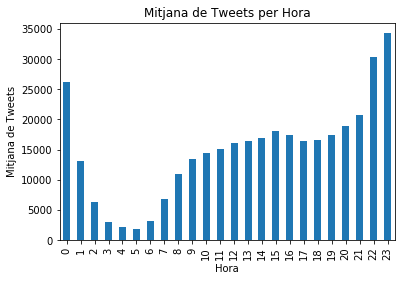

In [51]:
# YOUR CODE HERE

import pandas as pd
import matplotlib.pyplot as plt

tweets_hour_pd = tweets_hour.toPandas()
tweets_hour_pd.plot.bar(x='hour', y='tweets', legend=False)
plt.title('Mitjana de Tweets per Hora')
plt.xlabel('Hora')
plt.ylabel('Mitjana de Tweets')
plt.show()

### **Part 3.2:** Estratificat

En moltes ocasions el sampling homogeni no és adequat ja que la pròpia estructura de les dades fa que determinades poblacions estiguin sobrerepresentades. Aquest és el cas que observem en els tweets on les grans àrees urbanes estan sobrerepresentades si ho comparem amb el volum de població. En aquesta activitat veurem com aplicar aquesta tècnica al dataset de tweets, per obtenir un sampling que respecti la proporció de diputats per província.

A Espanya, el procés electoral assigna un volum de diputats a cada província que depèn de la població i d'un percentatge mínim assignat per llei. En el context Hive que hem creat prèviament (```hiveContext```) podem trobar una taula (``` province_28a```) que conté informació sobre les circumscripcions electorals. Carregueu aquesta taula en una variable amb nom ```province```.

In [90]:
# YOUR CODE HERE
province = hiveContext.sql("SELECT * FROM province_28a")
province.limit(20).show()

+-----------+-----------+------------------+----------+---------+
|    capital|   province|              ccaa|population|diputados|
+-----------+-----------+------------------+----------+---------+
|     Teruel|     Teruel|            Aragón|     35691|        3|
|      Soria|      Soria|   Castilla y León|     39112|        2|
|    Segovia|    Segovia|   Castilla y León|     51683|        3|
|     Huesca|     Huesca|            Aragón|     52463|        3|
|     Cuenca|     Cuenca|Castilla-La Mancha|     54898|        3|
|      Ávila|      Ávila|   Castilla y León|     57697|        3|
|     Zamora|     Zamora|   Castilla y León|     61827|        3|
|Ciudad Real|Ciudad Real|Castilla-La Mancha|     74743|        5|
|   Palencia|   Palencia|   Castilla y León|     78629|        3|
| Pontevedra| Pontevedra|           Galicia|     82802|        7|
|     Toledo|     Toledo|Castilla-La Mancha|     84282|        6|
|Guadalajara|Guadalajara|Castilla-La Mancha|     84910|        3|
|      Ceu

In [54]:
assert province.count() == 52, "Incorrect answer"

Per fer un sampling estratificat el primer que hem de fer és determinar la fracció que volem assignar a cada categoria. En aquest cas volem una fracció que faci que la fracció de tweets diputat sigui igual per a totes les capitals de província. Hem de tenir en compte que la precisió de la geolocalització a Twitter és normalment a nivell de ciutat. Per això, per evitar incrementar la complexitat de l'exercici, utilitzarem els tweets en capitals de província com a proxy dels tweets en tota la província.

El primer que heu de fer és crear un taula ```info_tweets_province``` que ha de contenir:
- ***capital:*** nom de la capital de província.
- ***tweets:*** nombre de tweets geolocalitzats a cada capital
- ***diputats:*** diputats que assignats a la província.
- ***ratio_tweets_diputado:*** nombre de tweets per diputat.

Heu d'ordenar la llista per ```ratio_tweets_diputado``` en ordre ascendent.

***Nota:*** Podeu fer aquest exercici de moltes maneres, probablement la més fàcil és utilitzar la taula ```tweets_place``` que heu generat en l'apartat 2.2.1. Recordeu com utilitzar el ```join ()```

In [55]:
# YOUR CODE HERE
info_tweets_province = tweets_place.join(province, tweets_place.name == province.capital)
info_tweets_province = info_tweets_province.withColumn("ratio_tweets_diputado", info_tweets_province.tweets / info_tweets_province.diputados)
info_tweets_province = info_tweets_province.select("capital", "tweets", "diputados", "ratio_tweets_diputado").orderBy("ratio_tweets_diputado")

#canviem diputados per diputats per a seguir exactament el que diu l'enunciat
info_tweets_province = info_tweets_province.withColumnRenamed("disputados", "diputats")

info_tweets_province.limit(20).show()

+--------------------+------+---------+---------------------+
|             capital|tweets|diputados|ratio_tweets_diputado|
+--------------------+------+---------+---------------------+
|              Teruel|     8|        3|   2.6666666666666665|
|          Pontevedra|    29|        7|    4.142857142857143|
|              Zamora|    23|        3|    7.666666666666667|
|              Huesca|    26|        3|    8.666666666666666|
|             Segovia|    28|        3|    9.333333333333334|
|               Cádiz|   108|        9|                 12.0|
|               Soria|    25|        2|                 12.5|
|              Cuenca|    39|        3|                 13.0|
|         Ciudad Real|    67|        5|                 13.4|
|                Lugo|    56|        4|                 14.0|
|            Pamplona|    77|        5|                 15.4|
|                Jaén|    86|        5|                 17.2|
|         Guadalajara|    56|        3|   18.666666666666668|
|       

In [56]:
output = info_tweets_province.first()
maximum_ratio = floor(output.ratio_tweets_diputado * 100) / 100
assert output.capital == "Teruel" and output.tweets == 8 and output.diputados == 3, "Incorrect output"

En aquesta cas el primer que necessitarem és un diccionari amb nom ```ratios``` on cada capital de província és una clau i el seu valor associat és la fracció de tweets que anem a samplejar. En aquest cas el que volem és que el ràtio de tweets per cada diputat sigui similar per a cada capital de província.

Com volem que el sampling sigui el més gran possible i no volem que cap capital quedi infrarepresentada el ràtio de tweets per diputat serà el valor més petit podeu observar a la taula ```info_tweets_province```, que correspon a 11.66 tweets per diputat a Terol. Teniu aquest valor guardat a la variable ```maximum_ratio```.

*Nota:* El mètode ```collectAsMap ()``` transforma un PairRDD en un diccionari.

In [58]:
# YOUR CODE HERE
print(maximum_ratio)
ratios = info_tweets_province.rdd.map(lambda x: (x.capital, maximum_ratio / x.ratio_tweets_diputado)).collectAsMap()

2.66
{'Ávila': 0.0876923076923077, 'Santa Cruz de Tenerife': 0.133, 'Alicante': 0.07842751842751844, 'Valladolid': 0.03982035928143713, 'Zaragoza': 0.0311892797319933, 'Zamora': 0.34695652173913044, 'Albacete': 0.12819277108433735, 'Girona': 0.06791489361702129, 'Lugo': 0.19, 'Oviedo': 0.056595744680851066, 'Cáceres': 0.14186666666666667, 'León': 0.0865040650406504, 'Santander': 0.07037037037037037, 'Murcia': 0.05770065075921909, 'Segovia': 0.285, 'Ceuta': 0.0665, 'Toledo': 0.12870967741935485, 'Palencia': 0.1191044776119403, 'Badajoz': 0.10857142857142858, 'Málaga': 0.053589743589743596, 'Guadalajara': 0.1425, 'Pontevedra': 0.6420689655172414, 'Cádiz': 0.22166666666666668, 'Castellón de la Plana': 0.10991735537190084, 'Huelva': 0.09047619047619049, 'Melilla': 0.021111111111111112, 'Burgos': 0.08184615384615385, 'Lleida': 0.07710144927536232, 'Teruel': 0.9975, 'Granada': 0.04597530864197531, 'Barcelona': 0.02445274346452169, 'Salamanca': 0.054564102564102566, 'Sevilla': 0.0332846715328

In [59]:
assert ratios['Albacete'] == 0.12819277108433735, "Incorrect output"

Genereu una taula ```geo_tweets``` amb tots els tweets geolocalitzats.

In [119]:
# YOUR CODE HERE
geo_tweets = tweets.filter(tweets.place.isNotNull())
geo_tweets.show(5)

+-------------------+-------------------+----+--------------------+----------------+--------------------+--------------------+
|                _id|         created_at|lang|               place|retweeted_status|                text|                user|
+-------------------+-------------------+----+--------------------+----------------+--------------------+--------------------+
|1117170058671923200|2019-04-13 22:57:52|  es|[[[[[2.052477, 41...|            null|@nasholop @PSOE N...|[1084, 1200, 8904...|
|1117170246685736960|2019-04-13 22:58:37|  es|[[[[[-4.654915, 4...|            null|@luttor007 @Sexta...|[509, 1014, 18878...|
|1117170260384395264|2019-04-13 22:58:40|  es|[[[[[-1.385233, 3...|            null|@JORDIARCE Aquí s...|[127, 314, 931553...|
|1117170273722294273|2019-04-13 22:58:43|  es|[[[[[-5.014957, 3...|            null|@DTrolera @Irene_...|[3027, 3139, 2982...|
|1117170471101968384|2019-04-13 22:59:30|  es|[[[[[2.052477, 41...|            null|@SoyDeDerechas @S...|[1263,

Ara ja estem en disposició de fer el sampling estratificat per població. Per a això podeu utilitzar el mètode ```sampleBy ()```. Utilitzeu 42 com seed de el generador pseudoaleatori.

**Esquema**
```Python
seed = 42
sample = <FILL IN>
```

In [142]:
# YOUR CODE HERE
sample = geo_tweets.sampleBy("place.name", ratios, seed)
sample.printSchema()

root
 |-- _id: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- lang: string (nullable = true)
 |-- place: struct (nullable = true)
 |    |-- bounding_box: struct (nullable = true)
 |    |    |-- coordinates: array (nullable = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: double (containsNull = true)
 |    |    |-- type: string (nullable = true)
 |    |-- country_code: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- place_type: string (nullable = true)
 |-- retweeted_status: struct (nullable = true)
 |    |-- _id: string (nullable = true)
 |    |-- user: struct (nullable = true)
 |    |    |-- followers_count: long (nullable = true)
 |    |    |-- friends_count: long (nullable = true)
 |    |    |-- id_str: string (nullable = true)
 |    |    |-- lang: string (nullable = true)
 

Per visualitzar el resultat de l'sampling aneu a crear una taula ```info_sample``` que contingui la següent informació:
- ***capital:*** nom de la capital de província.
- *** tweets:*** nombre de tweets samplejats a cada capital
- ***diputats:*** diputats que assignats a la província.
- ***ratio_tweets_diputado:*** nombre de tweets per diputat.

Ordeneu la taula resultant per ordre de ```ratio_tweets_diputado``` ascendent.

In [124]:
# YOUR CODE HERE
tweets_per_province = (
    sample
    .groupBy("place.name")
    .agg({"_id": "count"})
    .withColumnRenamed("place.name", "name")
    .withColumnRenamed("count(_id)", "tweets")
    .orderBy("tweets", ascending=False)
)
info_sample = tweets_per_province.join(province, tweets_per_province.name == province.capital)
info_sample = info_sample.withColumn("ratio_tweets_diputado", info_sample.tweets / info_sample.diputados)
info_sample = info_sample.select("capital", "tweets", "diputados", "ratio_tweets_diputado").orderBy("ratio_tweets_diputado", "tweets")
info_sample.limit(20).show()

+--------------------+------+---------+---------------------+
|             capital|tweets|diputados|ratio_tweets_diputado|
+--------------------+------+---------+---------------------+
|             Melilla|     1|        1|                  1.0|
|                Lugo|     4|        4|                  1.0|
|              Zamora|     5|        3|   1.6666666666666667|
|             Segovia|     5|        3|   1.6666666666666667|
|     Vitoria-Gasteiz|     7|        4|                 1.75|
|                León|     7|        4|                 1.75|
|           Santander|     9|        5|                  1.8|
|                Jaén|     9|        5|                  1.8|
|       San Sebastián|    11|        6|   1.8333333333333333|
|               Soria|     4|        2|                  2.0|
|              Cuenca|     6|        3|                  2.0|
|Las Palmas de Gra...|    16|        8|                  2.0|
|Castellón de la P...|    11|        5|                  2.2|
|       

In [125]:
output = info_sample.first()
assert output.capital == "Melilla" and output.tweets == 1  and output.diputados == 1 and output.ratio_tweets_diputado == 1.0, "Incorrect output"

Com veieu el sampling no és exacte, és una aproximació. Però com podeu imaginar apropar el sampling a la representativitat electoral de les regions és necessaris en molts casos.

Per comprovar-compteu primer tots els hashtags presents a la taula ```geo_tweets``` tal com hem fet en l'apartat 2.2.2 i ordeneu el resultat per nombre de tweets en ordre descendent. Deseu la taula en la variable `hashtagsTable`.

In [143]:
# YOUR CODE HERE
from pyspark.sql.functions import split, explode, count

hashtagsTable = (
    geo_tweets
    .select("_id", "text")
    .withColumn("hashtag", explode(split("text", ' ')))
    .filter("hashtag LIKE '#%'")
    .groupBy("hashtag")
    .agg(count("hashtag").alias("num"))
    .orderBy("num", ascending=False)
)


hashtagsTable.limit(20).show()

+--------------------+----+
|             hashtag| num|
+--------------------+----+
|                #28A|1286|
|   #ElDebateDecisivo| 724|
|     #ELDEBATEenRTVE| 646|
|         #HazQuePase| 274|
|#EleccionesGenera...| 259|
|       #EleccionesL6| 169|
|        #ValorSeguro| 163|
|   #DebateAtresmedia| 158|
|#EquiparacionYa
#...| 150|
|#EquiparacionYa
#...| 143|
|         #DebateRTVE| 140|
|           #DebatTV3| 123|
|#EleccionesGenerales| 106|
|         #EspañaViva| 103|
|             #España| 101|
|           #VotaPSOE|  91|
|            #28Abril|  87|
| #LaEspañaQueQuieres|  81|
|    #VamosCiudadanos|  80|
|#LaHistoriaLaEscr...|  80|
+--------------------+----+



In [140]:
output = hashtagsTable.first()
assert output.hashtag == "#28A" and output.num >= 1700, "Incorrect answer"

AssertionError: Incorrect answer

Compareu aquest resultat amb el que obtenim quan vam crear una taula ```hashtagsTable_sample``` on comptem els hashtags al mostra. Ordeneu la taula per nombre de tweets en ordre descendent.

In [137]:
# YOUR CODE HERE
hashtagsTable_sample = (
    sample
    .select("text")
    .withColumn("hashtag", explode(split("text", ' ')))
    .filter("hashtag LIKE '#%'")
    .groupBy("hashtag")
    .agg(count("hashtag").alias("num"))
    .orderBy("num", ascending=False)
)


hashtagsTable_sample.limit(20).show()

+--------------------+---+
|             hashtag|num|
+--------------------+---+
|                #28A| 34|
|   #ElDebateDecisivo| 22|
|     #ELDEBATEenRTVE| 13|
|         #HazQuePase|  8|
|         #DebateRTVE|  7|
|#EleccionesGenera...|  5|
|                #vox|  4|
|          #Catalunya|  3|
| #LauraBorrasEsForça|  3|
|             #España|  3|
| #LaEspañaQueQuieres|  3|
|        #ValorSeguro|  3|
|    #EstamosMuyCerca|  3|
|        #28AVotaPSOE|  3|
|#LaEspañaQueQuieres…|  2|
|                   #|  2|
|                #28a|  2|
|           #debatTV3|  2|
|           #VotaPSOE|  2|
|     #Elecciones2019|  2|
+--------------------+---+



In [138]:
output = hashtagsTable_sample.first()
assert output.hashtag == "#28A" and output.num >= 35, "Incorrect answer"

AssertionError: Incorrect answer

## **Part 4:** Introducció a les dades relacionals

El fet de treballar amb una base de dades que conté informació generada en una xarxa social ens permet introduir el concepte de dades relacionals. Podem definir dades relacionals com aquells en què les relacions entre les entitats constitueixen la base de dades. Sí aquestes relacions són binàries, relacions 1 a 1, podem representar les relacions com un graf compost per un conjunt de vèrtexs $\mathcal{V}$ i un conjunt d'arestes $\mathcal{E}$ que els relacionen.

En el cas de grafs que emergeixen de manera auto-organitzada l'estructura va més enllà dels grafs regulars que segurament coneixeu. Aquest tipus d'estructures es coneixen com [xarxes complexes](https://es.wikipedia.org/wiki/Red_compleja). L'estudi de l'estructura i propietats dinàmiques d'aquest tipus de xarxes ha contribuït a importants resultats en camps tan dispars com la física, la sociologia, l'ecologia o la medicina.

![Complex_network](https://images.squarespace-cdn.com/content/5150aec6e4b0e340ec52710a/1364574727391-XVOFAB9P6GHKTDAH6QTA/lastfm_800_graph_white.png?content-type=image%2Fpng)

En aquesta última part de la pràctica anem ha treballar amb aquest tipus de dades. En concret anem a modelar un dels possibles relacions presents en el dataset, la xarxa de retweets.

### **Part 4.1:** Generar la xarxa de retweets

#### **Part 4.1.1**: Construcció de la edgelist

El primer es demana que genereu la xarxa (el graf). Hi ha diverses maneres de representar una xarxa complexa, per exemple, si estem interessats a treballar-hi des del punt de vista teòric, la manera més habitual de representar-les és utilitzant una [matriu d'adjacència](https://ca.wikipedia.org/wiki/Matriu_d%27adjac%C3%A8ncia). En aquesta pràctica ens centrarem en l'aspecte computacional, una de les maneres de mes eficients (computacionalment parlant) de representar una xarxa és mitjançant la seva [*edge list*](https://en.wikipedia.org/wiki/Edge_list) , una taula que especifica la relació a parelles entre les entitats.

Les relacions poden ser bidireccionals o direccionals i tenir algun pes assignat o no (Weighted or unweighted). En el cas que ens ocupa, estem parlant d'una xarxa dirigida, un usuari retuiteja a un altre, i podem pensar-la tenint en compte quantes vegades això ha passat.

El primer que fareu per simplificar el còmput, és crear una mostra homogènia sense reemplaçament de l'1% dels tweets. Utilitzant els coneixements que heu après en l'apartat 3.1. Utilitzarem 42 com a valor per a la seed.

**Esquema**
```Python
seed = 42
sample = tweets.<FILL IN>
```

In [ ]:
# YOUR CODE HERE
seed = 42
fraction = 0.01

tweets_sample = tweets.sample(False, fraction, seed)

Creeu una taula ```edgelist``` amb la següent informació:
- ***src:*** usuari que retuiteja
- ***dst:*** usuari que és retuitejat
- ***weight:*** nombre de vegades que un usuari retuiteja a un altre.

Filtrar el resultat perquè contingui només les relacions amb un weight igual o major a dos.

In [ ]:
# YOUR CODE HERE
edgelist = tweets_sample.select(tweets_sample.retweeted_status.user.screen_name.alias("dst"), tweets_sample.user.screen_name.alias("src"))
edgelist = edgelist.filter("src IS NOT NULL and dst IS NOT NULL")
edgelist.limit(20).show()

edgelist = edgelist.groupBy("src", "dst").count().withColumnRenamed("count", "weight").filter("weight >= 2")
edgelist = edgelist.filter("weight >= 2")
L = edgelist.count()
print("There are {0} edges on the network.".format(L))


In [ ]:
assert L == 517, "Incorrect ouput"

#### **Part 4.1.2:** Centralitat de grau

Un dels descriptors més comuns en l'anàlisi de xarxes és el grau. El grau quantifica quantes arestes estan connectades a cada vèrtexs. En el cas de xarxes dirigides com la que acabem de crear aquest descriptor està descompost de:
- **n degree**: quantes arestes apunten el node
- **out degree**: quantes arestes surten de el node

Si fem un rànquing d'aquests valors obtindreu una mesura de centralitat, la [centralitat de grau](https://en.wikipedia.org/wiki/Centrality#Degree_centrality), de cadascun dels nodes.

Es demana que genereu una taula amb la següent informació:
- ***screen_name:*** nom de l'usuari.
- ***outDegree*** out degree de el node.

Ordenar la taula per out degree en ordre descendent.

In [ ]:
# YOUR CODE HERE
outDegree = edgelist.groupBy("src").agg(count("dst").alias("outDegree"))
outDegree = outDegree.orderBy("outDegree", ascending=False).withColumnRenamed("src", "screen_name")

outDegree.limit(20).show()


In [ ]:
output = outDegree.first()
assert output.screen_name == "Manudocalin" and output.outDegree == 3, "Incorrect output"

Es demana ara que genereu una taula `inDegree` con la informació:
- ***screen_name:*** nom de l'usuari.
- ***inDegree:*** in degree de el node.

Ordeneu la taula per in degree en ordre descendent.

In [ ]:
# YOUR CODE HERE
inDegree = edgelist.groupBy("dst").agg(count("src").alias("inDegree"))
inDegree = inDegree.orderBy("inDegree", ascending=False).withColumnRenamed("dst", "screen_name")

inDegree.limit(20).show()

In [ ]:
output = inDegree.first()
assert output.screen_name == "PSOE" and output.inDegree == 45, "Incorrect output"

### **Part 4.2:** Graphframes

Aquest tipus d'estructures és molt comú en molts datasets i el seu anàlisi cada vegada s'ha tornat més habitual. Per simplificar les operacions i l'anàlisi utilitzarem una llibreria específicament dissenyada per treballar en xarxes en sistemes distribuïts: [**Graphframes**](https://graphframes.github.io/graphframes/docs/_site/index.html) .

In [ ]:
import sys
pyfiles = str(sc.getConf().get(u'spark.submit.pyFiles')).split(',')
sys.path.extend(pyfiles)
from graphframes import *

El primer que anem a fer és crear un objecte ```GraphFrame``` que contindrà tota la informació de la xarxa.

En un pas previ ja hem creat la *edge list* ara crearem una llista amb els vèrtexs. Crear una taula ```vértices``` que contingui una única columna ``` id``` amb els nom d'usuari de tots els vèrtexs. Recordeu que hi ha vèrtexs que pot ser que només tinguin arestes incidents i altres que potser no tinguin (heu de fer servir la informació de les dues columnes de la ```edgelist```). Recordeu que la llista de vèrtexs és un conjunt on no hi pot haver repetició d'identificadors!

In [ ]:
# YOUR CODE HERE
src_vertices = edgelist.select("src").withColumnRenamed("src", "id")
dst_vertices = edgelist.select("dst").withColumnRenamed("dst", "id")
vertices = src_vertices.union(dst_vertices).distinct()
vertices = vertices.select("id")

N = vertices.count()
print("There are {0} nodes on the network.".format(N))

In [ ]:
assert N == 682, 'Incorrect output'

A l'igual que amb les arestes, podeu assignar atributs als vèrtexs. Genereu la taula `vertices_extended` fent un *inner join* per ``` id``` amb la taula ```user_info``` guardada en el context ``` hiveContext```. Ordeneu la taula resultant per followers en ordre descendent.


In [ ]:
# YOUR CODE HERE

user_info = hiveContext.table('user_info')

vertices_extended = vertices.join(user_info, vertices.id == user_info.id, "inner").select(user_info["*"], vertices["id"].alias("user_id"))

vertices_extended.limit(20).show()

In [ ]:
output = vertices_extended.first()
assert output.id == "el_pais" and output.lang == "es" and output.followers == 6904062

UnaUn cop tenim l'edgelist i la llista de vèrtexs estem en disposició d'instanciar [un objecte ```GraphFrame```](https://graphframes.github.io/graphframes/docs/_site/api/python/graphframes.html ). Instancieu aquest objecte a la variable ```network```.

In [ ]:
# YOUR CODE HERE
network = GraphFrame(vertices, edgelist)

In [ ]:
assert type(network) == GraphFrame, "Incorrect answer"

L'objecte que acabeu de crear té molts atributs i mètodes per a l'anàlisis de xarxes [(comproveu l'API)](https://graphframes.github.io/graphframes/docs/_site/api/python/graphframes.html). Es demana que utilitzeu l'atribut ```inDegrees``` de l'objecte que acabeu de crear per, conjuntament amb la transformació ``` orderBy```, generar una taula `inDegreeGraph` ordenada descendentement per grau.



In [ ]:
# YOUR CODE HERE
in_degrees = network.inDegrees
inDegreeGraph = in_degrees.orderBy("inDegree", ascending=False)

inDegreeGraph.limit(20).show()

In [ ]:
output = inDegreeGraph.first()
assert output.id == "PSOE" and output.inDegree == 45, "Incorrect answer"

Feu el mateix amb l'atribut ```outDegrees``` per, conjuntament amb la transformació ``` orderBy```,  generar una taula `outDegreeGraph` que conteng</mark> la informació del out degree en orden descendente.


In [ ]:
# YOUR CODE HERE
out_degrees = network.outDegrees
outDegreeGraph = out_degrees.orderBy("outDegree", ascending=False)

outDegreeGraph.limit(20).show()

In [ ]:
output = outDegreeGraph.first()
assert output.id == "Manudocalin" and output.outDegree == 3, "Incorrect answer"

### **Part 5:** Vídeo resposta - Dataframes (2 punt)

En aquest apartat s'haurà de respondre a les qüestions que es mostren a continuació mitjançant un vídeo resposta d'entre 5 i 10 minuts. Heu de realitzar una gravació en la qual se us vegi la cara responent amb les vostres pròpies paraules a les qüestions. Heu de seguir els següents punts per a realitzar el vídeo:

Al principi del vídeo heu de dir el vostre nom i DNI mentre mostreu el DNI (que ha de veure's amb claredat i ser llegible).

Heu de respondre a les preguntes en l'ordre en el qual estan, comentant sempre al principi de cada resposta a quina pregunta us esteu referint.

En el cas de no respondre a alguna pregunta, heu d'indicar el quina pregunta no contesteu i el perquè.

### Preguntes

1 - Expliqueu com s'ha treballat en grup (organització de tasques, canals de comunicació, etc.) i que ha fet cada membre del grup.

2 - Explica les diferències entre un SGBDR i Apatxe Hive.

3 - Explica les relacions que existeix entre Apatxe Hive, el seu Metastore i HDFS. 

4 - Realitza una comparativa detallada entre Apatxe Hive i Impala. 

5 - Explica el funcionament de Spark Accumulator 

6 - Explica quines opcions et semblen més útils per a connectar-se a una "Font de dades" amb Spark SQL

#Pugeu el vídeo al canvas.